# Algorithm:

In [1]:
# -*- coding: utf-8 -*-
"""
This is preprocess.py....

Created on Mon Apr  8 19:15:12 2019

@author: Quassarian Viper
"""


import numpy as np
import matplotlib.pyplot as plt
import cv2


def borders(here_img, thresh):
    size = here_img.shape
    check = int(115 * size[0] / 600)
    image = here_img[:]
    top, bottom = 0, size[0] - 1
    #plt.imshow(image)
    #plt.show()
    shape = size

    #find the background color for empty column
    bg = np.repeat(thresh, shape[1])
    count = 0
    for row in range(1, shape[0]):
        if  (np.equal(bg, image[row]).any()) == True:
            #print(count)
            count += 1
        else:
            count = 0
        if count >= check:
            top = row - check
            break
    
    
    shape = image.shape
    bg = np.repeat(thresh, shape[1])
    count = 0
    rows = np.arange(1, shape[0])
    #print(rows)
    for row in rows[::-1]:
        if  (np.equal(bg, image[row]).any()) == True:
            count += 1
        else:
            count = 0
        if count >= check:
            bottom = row + count
            break
    #print(count)
    
    
    #plt.imshow(here_img[top:bottom, :].T)
    #plt.show()
    
    d1 = (top - 2) >= 0 
    d2 = (bottom + 2) < size[0]
    d = d1 and d2
    if(d):
        b = 2
    else:
        b = 0
    
    return (top, bottom, b)


def detect_text(main_image, gray_img, localized, bc):        
        cimg = cv2.resize(localized, (30, 30))
        bordersize = 1
        nimg = cv2.copyMakeBorder(cimg, top=bordersize, bottom=bordersize, left=bordersize, right=bordersize, borderType=cv2.BORDER_CONSTANT, value=[255-bc, 0, 0])

        return main_image, nimg

def segmentation(bordered, thresh):
    try:
        shape = bordered.shape
        check = int(50 * shape[0] / 320)
        image = bordered[:]
        image = image[check:].T
        shape = image.shape
        #plt.imshow(image)
        #plt.show()

        #find the background color for empty column
        bg = np.repeat(255 - thresh, shape[1])
        bg_keys = []
        for row in range(1, shape[0]):
            if  (np.equal(bg, image[row]).all()):
                bg_keys.append(row)            

        lenkeys = len(bg_keys)-1
        new_keys = [bg_keys[1], bg_keys[-1]]
        #print(lenkeys)
        for i in range(1, lenkeys):
            if (bg_keys[i+1] - bg_keys[i]) > check:
                new_keys.append(bg_keys[i])
                #print(i)

        new_keys = sorted(new_keys)
        #print(new_keys)
        segmented_templates = []
        first = 0
        for key in new_keys[1:]:
            segment = bordered.T[first:key]
            segmented_templates.append(segment.T)
            #show middle segments
            #plt.imshow(segment.T)
            #plt.show()
            first = key
        last_segment = bordered.T[new_keys[-1]:]
        segmented_templates.append(last_segment.T)
        
        #check if each segment shape is enough to do recognition
        

        return(segmented_templates)
    except:
        return [bordered]
    
def localize(main_image, gray_img, localized, bc, show):
    #open the template as gray scale image
        template = localized
        #print(template.shape)
        width, height = template.shape[::-1] #get the width and height
        #match the template using cv2.matchTemplate
        match = cv2.matchTemplate(gray_img, template, cv2.TM_CCOEFF_NORMED)
        threshold = 0.8
        position = np.where(match >= threshold) #get the location of template in the image
        for point in zip(*position[::-1]): #draw the rectangle around the matched template
            cv2.rectangle(main_image, point, (point[0] + width, point[1] + height), (255 - bc, 0, bc ), 2)

        return main_image
    
    
def preprocess(bgr_img):#gray image   
    img = bgr_img[:]
    blur = cv2.GaussianBlur(img,(5,5),0)
    ret,th_img = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) #converts black to white and inverse

    rows, cols = th_img.shape
    bg_test = np.array([th_img[i][i] for i in range(5)])
    if bg_test.all() == 0:
        text_color = 255
    else:
        text_color = 0
    #print('Process: Localization....\n')
    tb = borders(th_img, text_color)
    lr = borders(th_img.T, text_color)
    dummy = int(np.average((tb[2], lr[2]))) + 2
    template = th_img[tb[0]+dummy:tb[1]-dummy, lr[0]+dummy:lr[1]-dummy]
    
    plt.imshow(template)
    plt.show()
    
    #print("Process: Segmentation....\n")
    segments = segmentation(template, text_color)
    
    #print('Process: Detection.....\n')
    return segments, template, th_img, text_color
    

    

#original_img = cv2.imread('1.png', 0)#gray image
#plt.imshow(original_img)
#plt.show()

#nimg = recognition(original_img)


In [2]:
# -*- coding: utf-8 -*-
"""
Created on Mon Apr  8 19:15:12 2019

@author: Quassarian Viper
"""
import numpy as np
from keras.models import model_from_json
from keras.models import load_model

def prediction(img):
    # load json and create model
    json_file = open('cnn2\cnn2.json', 'r')
    
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    
    # load weights into new model
    loaded_model.load_weights("cnn2\cnn2.h5")
    #print("Loaded model from disk")
    
    loaded_model.save('cnn.hdf5')
    loaded_model=load_model('cnn.hdf5')
    
    characters = '०,१,२,३,४,५,६,७,८,९,क,ख,ग,घ,ङ,च,छ,ज,झ,ञ,ट,ठ,ड,ढ,ण,त,थ,द,ध,न,प,फ,ब,भ,म,य,र,ल,व,श,ष,स,ह,क्ष,त्र,ज्ञ'
    characters = characters.split(',')
    
    x = np.asarray(img, dtype = np.float32).reshape(1, 32, 32, 1) / 255 
    
    output = loaded_model.predict(x)
    output = output.reshape(46)
    predicted = np.argmax(output)
    devanagari_label = characters[predicted]
    success = output[predicted] * 100
    
    return devanagari_label, success


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr 11 13:50:41 2019

@author: Quassarian Viper
"""
#from preprocess import preprocess, detect_text, localize
#from predictor import prediction
import numpy as np

def recognition(gray_image, show):
    segments, template, th_img, text_color = preprocess(gray_image)
    labels = []
    accuracy = []
    show_img = gray_image[:]
    #print(len(segments))
    
    for segment in segments: 
        #plt.imshow(segment)
        #plt.show()
        recimg, bimg = detect_text(show_img, th_img, segment, text_color)
        #print('Process: Recognition....\n')
        label, sure = prediction(bimg)
        if(sure > 80):
            #print(segment)
            labels.append(str(label))
            accuracy.append(sure)
            show_img = localize(show_img, th_img, segment, text_color, show)
        char = labels
    accuracy = np.average(accuracy)
    char = ''.join(char)
    if accuracy < 80:
        recimg, bimg = detect_text(show_img, th_img, template, text_color)
        show_img = localize(show_img, th_img, template, text_color, show)
        char, accuracy = prediction(bimg)
        
    if (show == 'show'):
        plt.imshow(show_img)
        plt.title('Detecting')
        plt.xticks([])
        plt.yticks([])
        plt.show()
    else:
        cv2.imshow('Detecting..', cv2.cvtColor(show_img, cv2.COLOR_GRAY2BGR))
    
    print('The prediction accuracy for ', char,' is ',"%.2f" % round(accuracy,2), '%')
    
    #plt.imshow(cv2.cvtColor(show_img, cv2.COLOR_GRAY2RGB))
    #plt.show()

In [4]:
# -*- coding: utf-8 -*-
"""
Created on Fri Apr 12 08:09:48 2019

@author: Quassarian Viper
"""
import cv2
import time
#from recognition import recognition

def camera(flag):
    choice = print("Click spacebar for photo and anything else for video.\n")
    orig = 1
    cap = cv2.VideoCapture(0)
    tr = 0.1
    br = 0.8
    lc = 0.1
    rc = 0.8
    f = 0
    
    while(flag):    
        ret, frame = cap.read()
        if ret:
            #key event
            s = cv2.waitKey(2) & 0xFF
            
            if(chr(s) == 'x'):
                f = -1
            if(chr(s) == 'z'):
                f = 1
            
            if(chr(s) == 'a'):
                tr = tr + 0.1 * f
            if(chr(s) == 'd'):
                br = br + 0.1 * f
            if (chr(s) == 's'):
                lc = lc + 0.1 * f
            if (chr(s) == 'w'):
                rc = rc + 0.1 * f
                
                
            s_x, s_y = np.shape(frame)[0] * tr, np.shape(frame)[1] * lc
            e_x, e_y = np.shape(frame)[1] * br, np.shape(frame)[0] * rc
            s_x, s_y = np.int32(s_x), np.int32(s_y)
            e_x, e_y = np.int32(e_x), np.int32(e_y)

            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            ogray = gray[:]
            gray = gray[s_y:e_y, s_x:e_x]
            #original = frame[s_y:e_y, s_x:e_x]
            
            if (s == 32): #space to capture image and do recognition
                time1 = time.time()
                plt.imshow(frame)
                plt.show()
                recognition(gray, 'show')
                print("In %f" %(time.time()-time1), 'sec')
            if (s == 13): #enter to do realtime recognition
                orig = 0
                cv2.destroyWindow('Project DCR')
                print("Doing RT...")
                recognition(ogray, 'no')
           
            
            else:
                if(orig != 0):
                    show = frame[:]
                    text = "Press 'space' to take a photo and 'enter' to do realtime(slow)."
                    text1 = "Make sure the character is inside rectangle."
                    text2 = "a/s/d/w for change rectangle and z/x for inc/dec."
                    cv2.putText(show, text1, (15, 50), cv2.FONT_HERSHEY_COMPLEX, 0.75, (0, 100, 200))
                    cv2.putText(show, text2, (0, np.shape(frame)[0] - 10), cv2.FONT_HERSHEY_COMPLEX, 0.65, (50, 20, 255))
                    cv2.rectangle(show, (s_x, s_y), (e_x, e_y), (0, 255, 0), 2)
                    cv2.putText(show, text, (15, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (15, 0, 255), lineType=cv2.LINE_AA) 
                    cv2.imshow('Project DCR', show)
        
        else:
            print('Trying.....\n')
            continue
         
        
        if s == 27:
            break
    cap.release()
    cv2.destroyAllWindows()

Please enter the image directory with name.
0.png


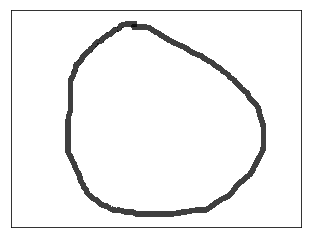

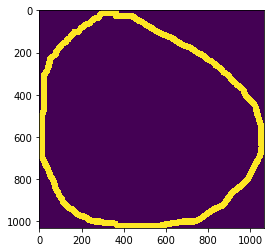

C:\ProgramData\Anaconda3\lib\site-packages\keras\models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


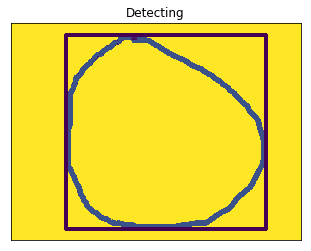

The prediction accuracy for  ०  is  100.00 %
In 2.585528 sec


In [7]:
# -*- coding: utf-8 -*-
"""
Created on Mon Apr  8 19:15:12 2019

@author: Quassarian Viper
"""
#from recognition import recognition
import cv2
import matplotlib.pyplot as plt
import time
#from video_test import camera

try: 
    test = input('Please enter the image directory with name.\n')
    test = cv2.imread(test, 0)
    plt.imshow(cv2.cvtColor(test, cv2.COLOR_GRAY2RGB))
    plt.xticks([])
    plt.yticks([])
    plt.show() 
    time1 = time.time()
    in_img = recognition(test, 'show')
    print("In %f" %(time.time()-time1), 'sec')
except:
    print("Image not found now turning to video mode.\n")
    try:
        camera(True)
    except:
        print('Something is wrong. Try with more stable, less noise and clear picture.\n')